In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import json
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("talk")
sns.set_style('white')
import numpy as np
import operator
from IPython.display import display as disp, HTML



In [3]:
sys.path.insert(0, os.path.abspath(".."))
# from optimizer import profiler
from optimizer import single_model_profiles as smp
from optimizer.single_model_profiles import create_model_profile_df as create_df
# import end_to_end_profiles as e2e_profiles
# from utils import COST_PER_GPU, COST_PER_CPU
# from end_to_end_profiles import load_end_to_end_experiment as load_e2e


In [4]:
smp.COST_PER_CPU, smp.COST_PER_GPU

(0.0475, 0.7)

## Single Model Perf Heterogeneity

In [5]:
profs = smp.load_single_model_profiles()

In [28]:
profs.keys()

dict_keys(['alexnet', 'res152', 'res18', 'res50', 'inception', 'tf-kernel-svm', 'tf-lang-detect', 'tf-log-reg', 'tf-lstm', 'tf-nmt', 'tf-resnet-feats'])

In [27]:
profs["res50"]

,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,cost,fname,cloud,gpu_type
0,1,48.735120,0.007172,0.023480,1.000000,0.7475,results-171024_103354.json,aws,k80
1,1,63.876475,0.065137,0.054294,1.937086,0.7475,results-171024_104943.json,aws,k80
2,1,76.283820,0.147900,0.094672,3.470630,0.7475,results-171024_105504.json,aws,k80
3,1,82.989348,0.535404,0.134883,5.416355,0.7475,results-171024_110037.json,aws,k80
4,1,84.551945,0.273012,0.134173,5.679155,0.7475,results-171024_110635.json,aws,k80
5,1,87.948107,0.201976,0.219028,9.533333,0.7475,results-171024_111224.json,aws,k80
6,1,90.520783,0.779330,0.236898,10.696159,0.7475,results-171024_111807.json,aws,k80
7,1,94.416129,1.196960,0.329699,15.199430,0.7475,results-171024_112315.json,aws,k80
8,1,92.449882,0.352055,0.414529,19.066667,0.7475,results-171024_112827.json,aws,k80
9,1,96.846859,2.051018,0.581078,27.752814,0.7475,results-171024_113540.json,aws,k80


In [13]:
def plot_smp_parameterized(prof, title, clouds=[], cpu_nums=[], gpu_types=[]):
    label_map = {"k80": "K80 (2014)",
                 "p100": "P100 (2016)",
                 "v100": "V100 (2017)",
                 "none": "CPU only"
                }
    num_colors = len(clouds)*len(cpu_nums)*len(gpu_types)
    colors = sns.color_palette("hls", n_colors=num_colors)
    color_idx = 0
    plt.clf()
    fig, (ax_thru, ax_lat) = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    dfs = []
    for cloud in clouds:
        for cpu in cpu_nums:
            for gpu in gpu_types:
                df = prof[(prof.cloud == cloud)
                                 & (prof.num_cpus_per_replica == cpu)
                                 & (prof.gpu_type == gpu)]
                if len(df) == 0:
                    continue
                df = df.sort_values("mean_batch_size")
                dfs.append(df)
                c = colors[color_idx]
                color_idx += 1
                label = "{cloud} {gpu} {cpu} CPUs".format(cloud=cloud,
                                                    gpu=gpu,
                                                    cpu=cpu)
                ax_thru.plot(df["mean_batch_size"], df["mean_throughput_qps"], color=c, label=label)
                ax_lat.plot(df["mean_batch_size"], df["p99_latency"], color=c, label=label)

    def make_legend(ax):
        handles, labels = ax.get_legend_handles_labels()
    
        hl = sorted(zip(handles, labels),
            key=operator.itemgetter(1))
        handles2, labels2 = zip(*hl)

        ax.legend(handles2, labels2, loc=0)
        
    ax_thru.set_xlabel("Batch size")
    ax_thru.set_ylabel("Throughput (qps)")
#     ax_thru.set_ylim((-3.4982116087534738, 230.74540662142903))
#     ax_thru.set_xlim((-2.7810096153846153, 80.401201923076925))
#     ax_thru.set_xlim(left=-10)
    make_legend(ax_thru)
    ax_lat.set_xlabel("Batch size")
    ax_lat.set_ylabel("p99 latency (s)")
    make_legend(ax_lat)
    fig.suptitle(title)
    plt.show()
    return dfs
    
    

# plot_smp_thrus(profs["res50"], "Resnet 50", plot_gcp=True, plot_aws=True)
# plot_smp_thrus(profs["res152"], "Resnet 152", plot_gcp=True, plot_aws=True)

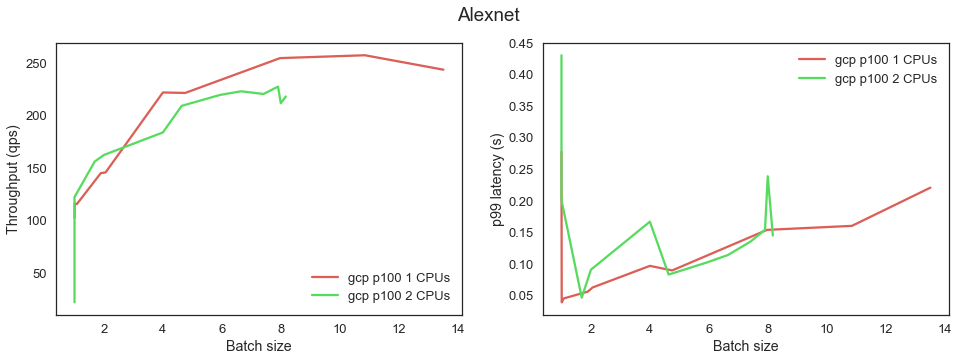

,num_cpus_per_replica,mean_throughput_qps,p99_latency,mean_batch_size,fname
33,1,102.547733,0.277349,1.000000,results-p100-1-1-180207_064829.json
36,1,116.412333,0.039291,1.008043,results-p100-1-2-180207_070422.json
37,1,115.722601,0.045533,1.080492,results-p100-1-20-180207_090203.json
38,1,145.197085,0.056294,1.894851,results-p100-1-24-180207_091851.json
35,1,145.784214,0.062769,2.054026,results-p100-1-16-180207_084513.json
40,1,221.796989,0.097003,4.000000,results-p100-1-4-180207_073435.json
39,1,221.340110,0.089756,4.756021,results-p100-1-32-180207_093623.json
42,1,254.448431,0.153939,7.977841,results-p100-1-8-180207_080202.json
34,1,257.159454,0.160270,10.856743,results-p100-1-12-180207_082911.json
41,1,243.445691,0.220722,13.520504,results-p100-1-48-180207_100623.json


,num_cpus_per_replica,mean_throughput_qps,p99_latency,mean_batch_size,fname
43,2,22.361260,0.430163,1.000000,results-p100-2-1-180205_122423.json
44,2,122.363657,0.201212,1.000000,results-p100-2-1-180205_215446.json
48,2,156.188478,0.046663,1.686710,results-p100-2-2-180205_220907.json
47,2,162.425741,0.090977,2.000000,results-p100-2-2-180205_212302.json
52,2,183.821526,0.166914,4.000000,results-p100-2-4-180206_004959.json
46,2,209.055462,0.083243,4.637411,results-p100-2-16-180206_015237.json
49,2,219.465360,0.102440,5.939848,results-p100-2-20-180206_020711.json
50,2,222.914179,0.114200,6.651267,results-p100-2-24-180206_022219.json
45,2,220.349022,0.135399,7.415802,results-p100-2-12-180206_013825.json
51,2,227.358345,0.154098,7.907945,results-p100-2-32-180206_023825.json


In [26]:
dfs = plot_smp_parameterized(profs["alexnet"],
                       "Alexnet",
                       clouds=["gcp"],
                       cpu_nums=[1,2,4],
                       gpu_types=["p100"])
for df in dfs:
    display(df[["num_cpus_per_replica", "mean_throughput_qps", "p99_latency", "mean_batch_size", "fname"]])
#     display(df)








In [ ]:
profs["alexnet"]